# Nhận dạng Ngôn ngữ Ký hiệu ASL với mô hình Transformer

Notebook này xây dựng một mô hình transformer để nhận dạng ngôn ngữ ký hiệu ASL sử dụng bộ dữ liệu từ cuộc thi Kaggle ASL Signs.

In [ ]:
!pip install -q tensorflow matplotlib pandas tqdm pyarrow

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tensorflow.keras import layers

print("GPU khả dụng:", tf.config.list_physical_devices('GPU'))

## 1. Tải và khám phá dữ liệu

In [3]:
DATA_DIR = '/kaggle/input/asl-signs'

train_df = pd.read_csv(f'{DATA_DIR}/train.csv')
print(f"Số lượng mẫu huấn luyện: {len(train_df)}")
print(train_df.head())

print(f"Số lượng nhãn khác nhau: {train_df['sign'].nunique()}")

top_signs = train_df['sign'].value_counts().head(10)
print(f"Các nhãn phổ biến nhất: {top_signs}")

Số lượng mẫu huấn luyện: 94477
                                            path  participant_id  sequence_id  \
0  train_landmark_files/26734/1000035562.parquet           26734   1000035562   
1  train_landmark_files/28656/1000106739.parquet           28656   1000106739   
2   train_landmark_files/16069/100015657.parquet           16069    100015657   
3  train_landmark_files/25571/1000210073.parquet           25571   1000210073   
4  train_landmark_files/62590/1000240708.parquet           62590   1000240708   

    sign  
0   blow  
1   wait  
2  cloud  
3   bird  
4   owie  
Số lượng nhãn khác nhau: 250
Các nhãn phổ biến nhất: sign
listen     415
look       414
shhh       411
donkey     410
mouse      408
duck       405
hear       405
uncle      405
pretend    404
bird       404
Name: count, dtype: int64


In [4]:
selected_signs = train_df['sign'].value_counts().head(10).index.tolist()
print(f"Ký hiệu được chọn: {selected_signs}")

filtered_train_df = train_df[train_df['sign'].isin(selected_signs)]
print(f"Số lượng mẫu sau khi lọc: {len(filtered_train_df)}")

for sign in selected_signs:
    count = len(filtered_train_df[filtered_train_df['sign'] == sign])
    print(f"Từ '{sign}': {count} mẫu")

Ký hiệu được chọn: ['listen', 'look', 'shhh', 'donkey', 'mouse', 'duck', 'hear', 'uncle', 'pretend', 'bird']
Số lượng mẫu sau khi lọc: 4081
Từ 'listen': 415 mẫu
Từ 'look': 414 mẫu
Từ 'shhh': 411 mẫu
Từ 'donkey': 410 mẫu
Từ 'mouse': 408 mẫu
Từ 'duck': 405 mẫu
Từ 'hear': 405 mẫu
Từ 'uncle': 405 mẫu
Từ 'pretend': 404 mẫu
Từ 'bird': 404 mẫu


In [5]:
sample_path = f"{DATA_DIR}/{train_df.iloc[0].path}"
sample_df = pd.read_parquet(sample_path)
print("Cấu trúc dữ liệu mẫu:")
print(sample_df.head())
print(f"Kích thước dữ liệu mẫu: {sample_df.shape}")

Cấu trúc dữ liệu mẫu:
   frame     row_id  type  landmark_index         x         y         z
0     20  20-face-0  face               0  0.494400  0.380470 -0.030626
1     20  20-face-1  face               1  0.496017  0.350735 -0.057565
2     20  20-face-2  face               2  0.500818  0.359343 -0.030283
3     20  20-face-3  face               3  0.489788  0.321780 -0.040622
4     20  20-face-4  face               4  0.495304  0.341821 -0.061152
Kích thước dữ liệu mẫu: (12489, 7)


## 2. Tiền xử lý dữ liệu

Dữ liệu gốc bao gồm các tọa độ điểm trên cơ thể, tay và khuôn mặt theo thời gian. Chúng ta cần xử lý và định dạng dữ liệu này để đưa vào mô hình transformer.

In [6]:
# Các điểm dữ liệu quan trọng 
LIP = [
    61, 185, 40, 39, 37, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
]
LHAND = np.arange(468, 489).tolist()
RHAND = np.arange(522, 543).tolist()
NOSE = [1,2,98,327]
REYE = [33, 7, 163, 144, 145, 153, 154, 155, 133, 246, 161, 160, 159, 158, 157, 173]
LEYE = [263, 249, 390, 373, 374, 380, 381, 382, 362, 466, 388, 387, 386, 385, 384, 398]
LEFT_EYEBROW = [70, 63, 105, 66, 107, 55, 65, 52, 53, 46]
RIGHT_EYEBROW = [336, 296, 334, 293, 300, 276, 283, 282, 295, 285]
FACE_OVAL = [10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 162, 21, 54, 103, 67, 109]
POINT_LANDMARKS = LIP + LHAND + RHAND + NOSE + REYE + LEYE + LEFT_EYEBROW + RIGHT_EYEBROW + FACE_OVAL

In [8]:
MAX_FRAMES = 384
TOTAL_LANDMARKS = 543

def load_and_preprocess_data(data_path):
    path_str = data_path.numpy().decode('utf-8')
    df = pd.read_parquet(path_str)
    
    landmarks = df[['x', 'y', 'z']].values
    
    n_frames = len(landmarks) // TOTAL_LANDMARKS
    if n_frames == 0:
        return np.zeros((MAX_FRAMES, TOTAL_LANDMARKS, 3), dtype=np.float32)
        
    landmarks = landmarks.reshape(n_frames, TOTAL_LANDMARKS, 3)
    
    if n_frames < MAX_FRAMES:
        padding = np.zeros((MAX_FRAMES - n_frames, TOTAL_LANDMARKS, 3))
        landmarks = np.vstack([landmarks, padding])
    else:
        landmarks = landmarks[:MAX_FRAMES, :, :]
    
    return landmarks.astype(np.float32)

In [7]:
# Xử lý dữ liệu NaN
def tf_nan_mean(x, axis=0, keepdims=False):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis, keepdims=keepdims) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis, keepdims=keepdims)

def tf_nan_std(x, center=None, axis=0, keepdims=False):
    if center is None:
        center = tf_nan_mean(x, axis=axis,  keepdims=True)
    d = x - center
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis, keepdims=keepdims))

class Preprocess(tf.keras.layers.Layer):
    def __init__(self, max_len=384, point_landmarks=POINT_LANDMARKS, **kwargs):
        super().__init__(**kwargs)
        self.max_len = max_len
        self.point_landmarks = point_landmarks

    def call(self, inputs):
        x = inputs
        mean = tf_nan_mean(tf.gather(x, [17], axis=2), axis=[1,2], keepdims=True)
        mean = tf.where(tf.math.is_nan(mean), tf.constant(0.5, x.dtype), mean)
        x = tf.gather(x, self.point_landmarks, axis=2)
        std = tf_nan_std(x, center=mean, axis=[1,2], keepdims=True)
        x = (x - mean) / std

        if self.max_len is not None:
            x = x[:, :self.max_len]
        
        length = tf.shape(x)[1]
        
        x = x[..., :2]
        x = tf.reshape(x, (-1, length, 2 * len(self.point_landmarks)))
        # ----------------------------------------
        
        x = tf.where(tf.math.is_nan(x), tf.constant(0., x.dtype), x)
        return x

## 3. Tạo tập dữ liệu TensorFlow

In [9]:
BATCH_SIZE = 64

# Chuyển đổi nhãn sign thành chỉ số số nguyên
unique_signs = sorted(selected_signs)
sign_to_id = {sign: idx for idx, sign in enumerate(unique_signs)}
id_to_sign = {idx: sign for sign, idx in sign_to_id.items()}
num_classes = len(unique_signs)

print(f"Tổng số lớp: {num_classes}")
print(f"Các từ ký hiệu được chọn: {unique_signs}")

Tổng số lớp: 10
Các từ ký hiệu được chọn: ['bird', 'donkey', 'duck', 'hear', 'listen', 'look', 'mouse', 'pretend', 'shhh', 'uncle']


In [10]:
def create_dataset(dataframe, batch_size=32, shuffle=True):
    paths = [f"{DATA_DIR}/{path}" for path in dataframe['path']]
    labels = [sign_to_id[sign] for sign in dataframe['sign']]
    
    @tf.function
    def process_path(path, label):
        landmarks = tf.py_function(
            func=load_and_preprocess_data,
            inp=[path],
            Tout=tf.float32
        )
        landmarks.set_shape((MAX_FRAMES, TOTAL_LANDMARKS, 3))
        
        label = tf.one_hot(label, depth=num_classes)
        
        return landmarks, label
    
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [11]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(filtered_train_df, test_size=0.2, random_state=2176, stratify=filtered_train_df['sign'])

print(f"Kích thước tập huấn luyện: {len(train_data)}")
print(f"Kích thước tập kiểm định: {len(val_data)}")

# Tạo dataset TensorFlow
train_dataset = create_dataset(train_data, batch_size=BATCH_SIZE)
val_dataset = create_dataset(val_data, batch_size=BATCH_SIZE, shuffle=True)

Kích thước tập huấn luyện: 3264
Kích thước tập kiểm định: 817


## 4. Xây dựng mô hình Transformer

In [12]:
def positional_encoding(length, depth):
    depth = depth/2
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :]/depth
    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates
    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)], axis=-1) 
    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(layers.Layer):
    def __init__(self, d_model, max_len=MAX_FRAMES):
        super().__init__()
        self.d_model = d_model
        self.pos_encoding = positional_encoding(length=max_len, depth=d_model)
        self.supports_masking = True

    def call(self, x):
        length = tf.shape(x)[1]
        return x + self.pos_encoding[:length, :]

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    attn_output = layers.MultiHeadAttention(
        key_dim=head_size,
        num_heads=num_heads,
        dropout=dropout
    )(x, x)
    
    x = layers.Add()([inputs, attn_output])
    
    # Feed Forward Network
    y = layers.LayerNormalization(epsilon=1e-6)(x)
    y = layers.Dense(ff_dim, activation='gelu')(y)
    y = layers.Dropout(dropout)(y)
    y = layers.Dense(inputs.shape[-1])(y)
    y = layers.Dropout(dropout)(y)
    
    return layers.Add()([x, y])

def build_transformer_model(num_classes):
    inputs = tf.keras.Input(shape=(MAX_FRAMES, TOTAL_LANDMARKS, 3))
    
    x = Preprocess(max_len=MAX_FRAMES)(inputs) 
    
    x = layers.Masking(mask_value=0.0)(x)

    head_size = 64
    num_heads = 4
    d_model = head_size * num_heads
    ff_dim = 128 
    transformer_layers = 4
    mlp_units = [128]
    dropout = 0.2
    mlp_dropout = 0.4
    
    x = layers.Dense(d_model)(x)
    x = PositionalEmbedding(d_model=d_model)(x)
    x = layers.Dropout(dropout)(x)
    
    for _ in range(transformer_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    x = layers.GlobalAveragePooling1D()(x)
    
    x = layers.LayerNormalization(epsilon=1e-6)(x) 
    for dim in mlp_units:
        x = layers.Dense(dim, activation="gelu")(x)
        x = layers.Dropout(mlp_dropout)(x)
        
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return tf.keras.Model(inputs, outputs)

In [13]:
# Kiểm tra để lấy kích thước input chính xác
for x, y in train_dataset.take(1):
    print(f"Kích thước dữ liệu đầu vào: {x.shape}")
    print(f"Kích thước nhãn: {y.shape}")

model = build_transformer_model(num_classes)
model.summary()

Kích thước dữ liệu đầu vào: (64, 384, 543, 3)
Kích thước nhãn: (64, 10)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 384, 543,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocess          │ (None, 384, 346)  │          0 │ input_layer[0][0] │
│ (Preprocess)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 384, 346)  │          0 │ preprocess[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 384, 256)  │     88,832 │ masking[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 384, 256)  │          0 │ dense[0][0]       │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384, 256)  │          0 │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 384, 346)  │          0 │ preprocess[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 384, 256)  │        512 │ dropout[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 384)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 384, 256)  │    263,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ any[0][0],        │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 384, 256)  │          0 │ dropout[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 384, 256)  │        512 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 384, 128)  │     32,896 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 384, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 384, 256)  │     33,024 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 384, 256)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 384, 256)  │          0 │ add[0][0],        │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logical_or          │ (None, 384)       │          0 │ any[0][0],        │
│ (LogicalOr)         │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 384, 256)  │        512 │ add_1[0][0]     

 Total params: 1,443,978 (5.51 MB)

 Trainable params: 1,443,978 (5.51 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Huấn luyện mô hình

In [14]:
# Biên dịch mô hình
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

In [15]:
# Thiết lập các callbacks
# Giảm learning rate khi mô hình không cải thiện
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6
)

# Dừng sớm nếu mô hình không cải thiện
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# Lưu mô hình tốt nhất
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras", monitor="val_loss", save_best_only=True
)

In [16]:
# Huấn luyện mô hình
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 427s 8s/step - accuracy: 0.1006 - loss: 2.5017 - val_accuracy: 0.1444 - val_loss: 2.2971 - learning_rate: 1.0000e-04
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 409s 8s/step - accuracy: 0.0984 - loss: 2.3105 - val_accuracy: 0.1138 - val_loss: 2.2886 - learning_rate: 1.0000e-04
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 407s 8s/step - accuracy: 0.1228 - loss: 2.2916 - val_accuracy: 0.1567 - val_loss: 2.2683 - learning_rate: 1.0000e-04
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 410s 8s/step - accuracy: 0.1538 - loss: 2.2473 - val_accuracy: 0.2203 - val_loss: 2.0649 - learning_rate: 1.0000e-04
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 408s 8s/step - accuracy: 0.2118 - loss: 2.0786 - val_accuracy: 0.2791 - val_loss: 1.9266 - learning_rate: 1.0000e-04
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 408s 8s/step - accuracy: 0.2529 - loss: 2.0011 - val_accuracy: 0.3170 - val_loss: 1.8062 - learning_rate: 1.0000e-04
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 407s 8s/step - accuracy: 

## 6. Đánh giá và trực quan hóa kết quả

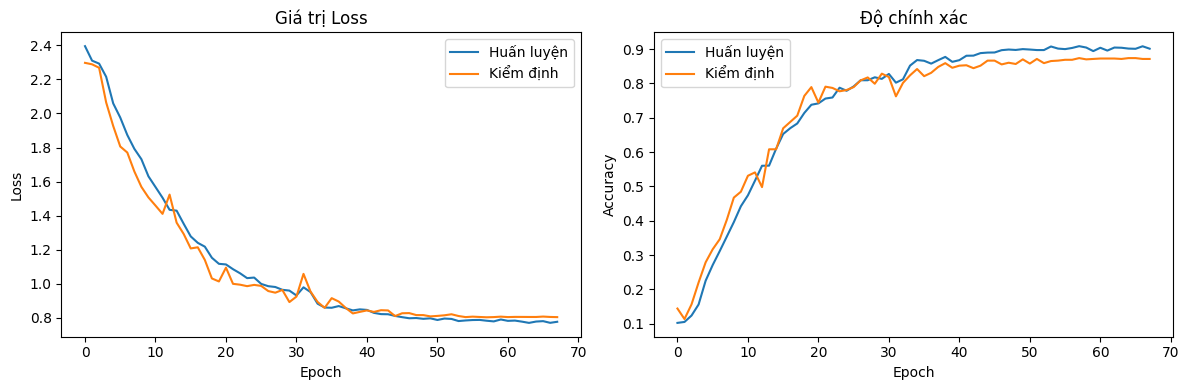

In [17]:
# Vẽ đồ thị loss và accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Huấn luyện')
plt.plot(history.history['val_loss'], label='Kiểm định')
plt.title('Giá trị Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Huấn luyện')
plt.plot(history.history['val_accuracy'], label='Kiểm định')
plt.title('Độ chính xác')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Đánh giá mô hình trên tập kiểm định
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Độ chính xác trên tập kiểm định: {val_accuracy:.4f}")
print(f"Loss trên tập kiểm định: {val_loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.8765 - loss: 0.8043
Độ chính xác trên tập kiểm định: 0.8739
Loss trên tập kiểm định: 0.8038


In [25]:

def visualize_predictions(dataset, num_samples=50):
    for images, labels in dataset.take(1):
        predictions = model.predict(images, verbose=0)
        
        for i in range(num_samples):
            true_label_vector = labels[i]
            true_class_id = np.argmax(true_label_vector) 
            
            pred_prob_vector = predictions[i]
            pred_class_id = np.argmax(pred_prob_vector)
            
            print(f"Mẫu {i+1}:")
            print(f"  Nhãn thực: {id_to_sign[true_class_id]} (ID: {true_class_id})")
            print(f"  Dự đoán:   {id_to_sign[pred_class_id]} (ID: {pred_class_id})")
            
            confidence = pred_prob_vector[pred_class_id]
            print(f"  Độ tin cậy: {confidence:.2f}")
            
            if true_class_id == pred_class_id:
                print("  Kết quả: ĐÚNG")
            else:
                print("  Kết quả: SAI")
            print("---")
visualize_predictions(val_dataset)

Mẫu 1:
  Nhãn thực: shhh (ID: 8)
  Dự đoán:   shhh (ID: 8)
  Độ tin cậy: 0.94
  Kết quả: ĐÚNG
---
Mẫu 2:
  Nhãn thực: mouse (ID: 6)
  Dự đoán:   mouse (ID: 6)
  Độ tin cậy: 0.90
  Kết quả: ĐÚNG
---
Mẫu 3:
  Nhãn thực: shhh (ID: 8)
  Dự đoán:   shhh (ID: 8)
  Độ tin cậy: 0.97
  Kết quả: ĐÚNG
---
Mẫu 4:
  Nhãn thực: shhh (ID: 8)
  Dự đoán:   shhh (ID: 8)
  Độ tin cậy: 0.97
  Kết quả: ĐÚNG
---
Mẫu 5:
  Nhãn thực: uncle (ID: 9)
  Dự đoán:   uncle (ID: 9)
  Độ tin cậy: 0.98
  Kết quả: ĐÚNG
---
Mẫu 6:
  Nhãn thực: shhh (ID: 8)
  Dự đoán:   shhh (ID: 8)
  Độ tin cậy: 0.98
  Kết quả: ĐÚNG
---
Mẫu 7:
  Nhãn thực: uncle (ID: 9)
  Dự đoán:   uncle (ID: 9)
  Độ tin cậy: 0.99
  Kết quả: ĐÚNG
---
Mẫu 8:
  Nhãn thực: duck (ID: 2)
  Dự đoán:   duck (ID: 2)
  Độ tin cậy: 0.96
  Kết quả: ĐÚNG
---
Mẫu 9:
  Nhãn thực: hear (ID: 3)
  Dự đoán:   hear (ID: 3)
  Độ tin cậy: 0.37
  Kết quả: ĐÚNG
---
Mẫu 10:
  Nhãn thực: look (ID: 5)
  Dự đoán:   look (ID: 5)
  Độ tin cậy: 0.95
  Kết quả: ĐÚNG
---
Mẫu 11:
  Nhã

Báo cáo phân loại:
              precision    recall  f1-score   support

        bird       0.93      0.95      0.94        81
      donkey       0.97      0.93      0.95        82
        duck       0.95      0.91      0.93        81
        hear       0.68      0.80      0.74        81
      listen       0.75      0.63      0.68        83
        look       0.87      0.92      0.89        83
       mouse       0.87      0.89      0.88        82
     pretend       0.88      0.85      0.87        81
        shhh       0.92      0.93      0.92        82
       uncle       0.93      0.94      0.93        81

    accuracy                           0.87       817
   macro avg       0.88      0.87      0.87       817
weighted avg       0.88      0.87      0.87       817

Ma trận nhầm lẫn


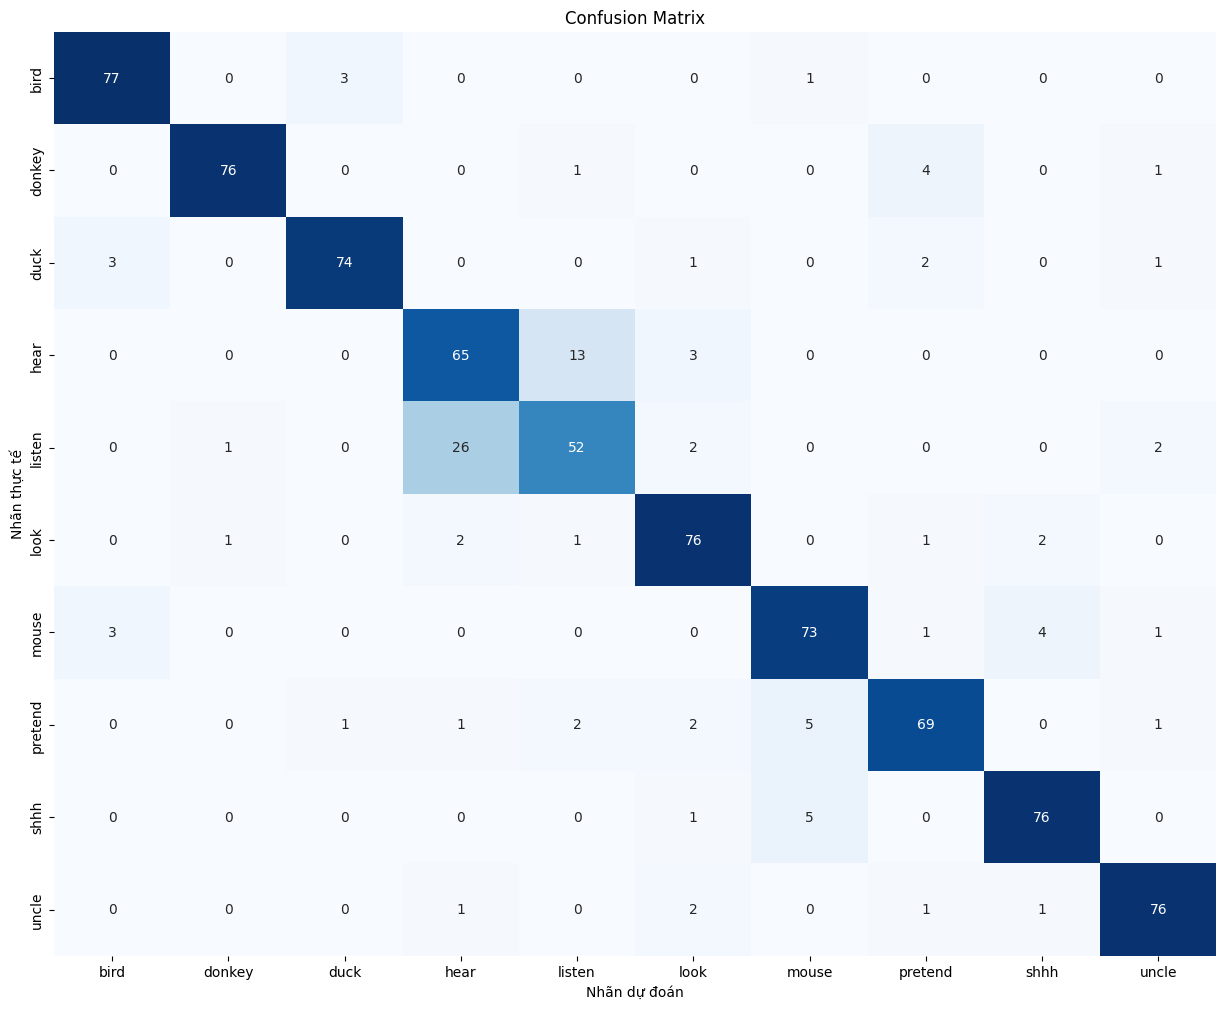

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def visualize_confusion_matrix(dataset):
    true_labels = []
    pred_labels = []

    for images, labels in dataset:
        predictions = model.predict(images, verbose=0) 
        pred_classes = np.argmax(predictions, axis=1) 
        true_classes = np.argmax(labels, axis=1) 
        true_labels.extend(true_classes) 
        pred_labels.extend(pred_classes) 

    class_names = [id_to_sign[i] for i in range(num_classes)]
    
    print("Báo cáo phân loại:")
    print(classification_report(true_labels, pred_labels, target_names=class_names, zero_division=0))
    
    print("Ma trận nhầm lẫn")
    cm = confusion_matrix(true_labels, pred_labels)
    
    plt.figure(figsize=(15, 12))
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names) 
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('Nhãn thực tế')
    plt.xlabel('Nhãn dự đoán')
    plt.show()
visualize_confusion_matrix(val_dataset)

## 7. Lưu mô hình và Demo

In [21]:
# Lưu mô hình cuối cùng
model.save('asl_transformer_model.keras')
print("Đã lưu mô hình thành công")

Đã lưu mô hình thành công


In [24]:
# Demo
import matplotlib.animation as animation
from IPython.display import HTML

POSE_CONNECTIONS = [(11, 13), (13, 15), (12, 14), (14, 16), (11, 12), (11, 23), (12, 24), (23, 24)]
POSE_OFFSET = 489 
HAND_CONNECTIONS = [(0, 1), (1, 2), (2, 3), (3, 4), (0, 5), (5, 6), (6, 7), (7, 8), (0, 9), (9, 10), (10, 11), (11, 12), (0, 13), (13, 14), (14, 15), (15, 16), (0, 17), (17, 18), (18, 19), (19, 20), (5, 9), (9, 13), (13, 17)]
LHAND_OFFSET = 468
RHAND_OFFSET = 522
FACE_OVAL = [10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 162, 21, 54, 103, 67, 109, 10]
LIPS = [61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 61]
LEFT_EYE = [33, 160, 158, 133, 153, 144, 33]
RIGHT_EYE = [362, 385, 387, 263, 373, 380, 362]
LEFT_EYEBROW = [70, 63, 105, 66, 107, 55, 65, 52, 53, 46]
RIGHT_EYEBROW = [336, 296, 334, 293, 300, 276, 283, 282, 295, 285]

def create_connections(indices): return [(indices[i], indices[i+1]) for i in range(len(indices)-1)]
FACE_CONNECTIONS = (create_connections(FACE_OVAL) + create_connections(LIPS) + create_connections(LEFT_EYE) + create_connections(RIGHT_EYE) + create_connections(LEFT_EYEBROW) + create_connections(RIGHT_EYEBROW))
FACE_OFFSET = 0

def draw_skeleton(ax, frame_data):
    # Vẽ Khuôn Mặt
    for start, end in FACE_CONNECTIONS:
        s_idx, e_idx = start + FACE_OFFSET, end + FACE_OFFSET
        if np.sum(frame_data[s_idx]) != 0 and np.sum(frame_data[e_idx]) != 0:
            ax.plot([frame_data[s_idx, 0], frame_data[e_idx, 0]], [frame_data[s_idx, 1], frame_data[e_idx, 1]], color='lightgray', alpha=0.6, linewidth=1)
    # Vẽ Cơ thể
    for start, end in POSE_CONNECTIONS:
        s_idx, e_idx = start + POSE_OFFSET, end + POSE_OFFSET
        if np.sum(frame_data[s_idx]) != 0 and np.sum(frame_data[e_idx]) != 0:
            ax.plot([frame_data[s_idx, 0], frame_data[e_idx, 0]], [frame_data[s_idx, 1], frame_data[e_idx, 1]], color='white', alpha=0.8, linewidth=2)
    # Vẽ Tay Trái
    for start, end in HAND_CONNECTIONS:
        s_idx, e_idx = start + LHAND_OFFSET, end + LHAND_OFFSET
        if np.sum(frame_data[s_idx]) != 0 and np.sum(frame_data[e_idx]) != 0:
            ax.plot([frame_data[s_idx, 0], frame_data[e_idx, 0]], [frame_data[s_idx, 1], frame_data[e_idx, 1]], color='#00ff00', alpha=0.9, linewidth=1.5)
    # Vẽ Tay Phải
    for start, end in HAND_CONNECTIONS:
        s_idx, e_idx = start + RHAND_OFFSET, end + RHAND_OFFSET
        if np.sum(frame_data[s_idx]) != 0 and np.sum(frame_data[e_idx]) != 0:
            ax.plot([frame_data[s_idx, 0], frame_data[e_idx, 0]], [frame_data[s_idx, 1], frame_data[e_idx, 1]], color='#ff0055', alpha=0.9, linewidth=1.5)


def calculate_zoom_limits(landmarks, padding=0.1):
    valid_x = landmarks[:, :, 0][landmarks[:, :, 0] != 0]
    valid_y = landmarks[:, :, 1][landmarks[:, :, 1] != 0]
    
    if len(valid_x) == 0 or len(valid_y) == 0:
        return (0, 1), (1, 0)
        
    min_x, max_x = valid_x.min(), valid_x.max()
    min_y, max_y = valid_y.min(), valid_y.max()
    
    range_x = max_x - min_x
    range_y = max_y - min_y
    max_range = max(range_x, range_y)
    
    radius = (max_range / 2) * (1 + padding)
    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2
    
    return (center_x - radius, center_x + radius), (center_y + radius, center_y - radius)


def animate_zoomed_skeleton(landmarks, true_label, pred_label, confidence):
    landmarks = np.nan_to_num(landmarks, nan=0.0)
    non_empty = np.sum(np.abs(landmarks), axis=(1, 2)) > 0
    if np.any(non_empty):
        landmarks = landmarks[:np.max(np.where(non_empty))+1]
    
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(5, 5))
    
    title_color = '#00ff00' if true_label == pred_label else '#ff0000'
    ax.set_title(f"True: {true_label} | Pred: {pred_label} ({confidence:.0%})", color=title_color, fontsize=14)
    ax.axis('off')
    
    xlim, ylim = calculate_zoom_limits(landmarks, padding=0.2)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    def update(frame_idx):
        ax.clear()
        ax.axis('off')
        ax.set_title(f"True: {true_label} | Pred: {pred_label} ({confidence:.0%})", color=title_color, fontsize=14)
        
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        draw_skeleton(ax, landmarks[frame_idx])
        return ax,

    anim = animation.FuncAnimation(fig, update, frames=len(landmarks), interval=50, blit=False)
    plt.close()
    return HTML(anim.to_jshtml())

def run_demo_zoomed(dataset, model):
    print("Đang xử lý video")
    
    for inputs, targets in dataset.take(1):
        idx = np.random.randint(0, inputs.shape[0])
        sample_input = inputs[idx].numpy()
        true_label_vector = targets[idx].numpy()
        true_label_id = np.argmax(true_label_vector) 
        input_batch = np.expand_dims(sample_input, axis=0)
        
        pred = model.predict(input_batch, verbose=0)[0]
        
        true_text = id_to_sign[true_label_id]
        pred_text = id_to_sign[np.argmax(pred)]
        conf = np.max(pred)
        
        return animate_zoomed_skeleton(sample_input, true_text, pred_text, conf)

run_demo_zoomed(val_dataset, model)

Đang xử lý video


## 8. Kết luận